In [2]:
## import some basic python packages
import pandas as pd
import numpy as np

## LinearElasticityHZFEMRate2D

In [1]:
import argparse
import numpy as np
import sympy as sp
import sys
from scipy.sparse import coo_matrix, csc_matrix, csr_matrix, spdiags, eye, bmat, construct
from scipy.sparse.linalg import spsolve

import matplotlib.pyplot as plt


import fealpy.mesh.MeshFactory as mf
from fealpy.mesh import TriangleMesh

## function space
from fealpy.functionspace.HuZhangFiniteElementSpace2D import HuZhangFiniteElementSpace
from fealpy.functionspace.LagrangeFiniteElementSpace import LagrangeFiniteElementSpace

#linear elasticity model
from fealpy.pde.linear_elasticity_model import QiModel3d, PolyModel3d, Model2d, HuangModel2d
from fealpy.pde.linear_elasticity_model2D import GenLinearElasticitymodel2D

#solver 
from fealpy.solver.fast_solver import LinearElasticityHZFEMFastSolve



## error anlysis tool
from fealpy.tools.show import showmultirate




##  参数解析
parser = argparse.ArgumentParser(description=
        """
        三角形网格上用胡张元求解线弹性力学问题
        """)


parser.add_argument('--degree',
        default=3, type=int,
        help='Lagrange 有限元空间的次数, 默认为 3 次.')

parser.add_argument('--nrefine',
        default=2, type=int,
        help='初始网格加密的次数, 默认初始加密 2 次.')

parser.add_argument('--maxit',
        default=4, type=int,
        help='默认网格加密求解的次数, 默认加密求解 4 次')

parser.add_argument('--bdtype',
        default='displacement', type=str,
        help='边界条件, 默认为位移边界')

args = parser.parse_args()

degree = args.degree
nrefine = args.nrefine
maxit = args.maxit
bdtype = args.bdtype


#由位移生成pde模型
#E = 1e3
#nu = 0.3
#lam = E*nu/((1+nu)*(1-2*nu))
#mu = E/(2*(1+nu))


pi = sp.pi
sin = sp.sin
cos = sp.cos
exp = sp.exp
ln = sp.ln

#给定应力算例
lam = 1
mu = 1

#一般pde算例
x = sp.symbols('x0:2')
#u = [0.01*(1-x[0]),0]
#u = [sin(2*pi*x[0])*sin(2*pi*x[1]),sin(2*pi*x[0])*sin(2*pi*x[1])]
#u = [exp(x[0]+x[1]),exp(x[0]-x[1])]
#u = [x[0],x[1]]
#u = [0,(x[0]-1)**7*(x[1]-1)**7]
u = [-(1-x[0])*ln(1.5-x[0]),-(1-x[0])*ln(1.5-x[1])]
#u = [sin(2*pi*x[0])*sin(2*pi*x[1]),sin(2*pi*x[0])*sin(2*pi*x[1])]


if bdtype == 'displacement': 
        pde = GenLinearElasticitymodel2D(u,x,lam=lam,mu=mu,
                Dirichletbd_n='(x0==1)|(x0==0)|(x1==0)|(x1==1)',
                Dirichletbd_t='(x0==1)|(x0==0)|(x1==0)|(x1==1)')

elif bdtype =='stress_and_displacement':
        pde = GenLinearElasticitymodel2D(u,x,lam=lam,mu=mu,
                Dirichletbd_n='(x1==0)|(x1==1)',Dirichletbd_t='(x1==0)|(x1==1)',
                Neumannbd_nn='(x0==1)|(x0==0)',Neumannbd_nt='(x0==1)|(x0==0)')

elif bdtype =='stress_and_displacement_corner_point':
        pde = GenLinearElasticitymodel2D(u,x,lam=lam,mu=mu,
                Dirichletbd_n='(x0==1)|(x1==1)',Dirichletbd_t='(x0==1)|(x1==1)',
                Neumannbd_nn='(x0==0)|(x1==0)',Neumannbd_nt='(x0==0)|(x1==0)')
                        



mesh = mf.boxmesh2d(pde.domain(),nx=1,ny=1,meshtype='tri')
mesh.uniform_refine(nrefine)



errorType = ['$||\sigma - \sigma_h ||_{0}$',
        '$||div(\sigma - \sigma_h)||_{0}$',
        '$||u - u_h||_{0}$'
        ]
Ndof = np.zeros((maxit,))
errorMatrix = np.zeros((len(errorType), maxit), dtype=np.float)
gdim = 2

for i in range(maxit):
        print("The {}-th computation:".format(i))

        tspace = HuZhangFiniteElementSpace(mesh, degree)
        vspace = LagrangeFiniteElementSpace(mesh, degree-1, spacetype='D') 

        tgdof = tspace.number_of_global_dofs()
        vgdof = vspace.number_of_global_dofs()

        sh = tspace.function()
        uh = vspace.function(dim=gdim)

        #M = tspace.compliance_tensor_matrix(mu=pde.mu,lam=pde.lam)
        M = tspace.parallel_compliance_tensor_matrix(mu=pde.mu,lam=pde.lam)

        #B0,B1 = tspace.div_matrix(vspace)
        B0,B1 = tspace.parallel_div_matrix(vspace)
        #print(np.max(np.abs(B0-B10)))

        F1 =  -vspace.source_vector(pde.source,dim=gdim)


        #边界处理
        F0 = tspace.set_nature_bc(pde.dirichlet,threshold=pde.is_dirichlet_boundary) #此处以位移边界为dirichlet边界

        isBDdof = tspace.set_essential_bc(sh, pde.neumann,M,B0,B1,F0, threshold=pde.is_neumann_boundary)#以应力边界为neumann边界


        F0 -= M@sh
        F0[isBDdof] = sh[isBDdof]
        F1[:,0] -= B0@sh 
        F1[:,1] -= B1@sh
        

        bdIdx = np.zeros(tgdof, dtype=np.int)
        bdIdx[isBDdof] = 1
        Tbd = spdiags(bdIdx,0,tgdof,tgdof)
        T = spdiags(1-bdIdx,0,tgdof,tgdof)
        M = T@M@T + Tbd
        B0 = B0@T
        B1 = B1@T
        


        #求解
        #FF = np.r_[F0,F1.T.reshape(-1)]
        #AA = bmat([[M, B0.transpose(), B1.transpose()],[B0, None, None],[B1,None,None]],format='csr')
        #x = spsolve(AA,FF)

        B = construct.vstack([B0,B1],format='csr')
        A = [M,B]
        F = [F0,F1]
        Fast_slover = LinearElasticityHZFEMFastSolve(A,F,vspace)
        x = Fast_slover.solve()




        sh[:] = x[:tgdof]
        uh[:,0] = x[tgdof:tgdof+vgdof]
        uh[:,1] = x[tgdof+vgdof:]
 
        gdof = tgdof+gdim*vgdof
        Ndof[i] = gdof

        #有限元误差
        errorMatrix[0,i] = tspace.integralalg.error(pde.stress,sh.value)
        errorMatrix[1,i] = tspace.integralalg.error(pde.div_stress,sh.div_value)
        errorMatrix[2,i] = vspace.integralalg.error(pde.displacement,uh.value)        
        if i < maxit - 1:
                mesh.uniform_refine()

       
print('Ndof:', Ndof)
print('error:', errorMatrix)
showmultirate(plt, 0, Ndof, errorMatrix, errorType)
plt.show()      

ModuleNotFoundError: No module named 'fealpy.functionspace.HuZhangFiniteElementSpace2D'

## HuZhangFiniteElementSpace

In [3]:
class HuZhangFiniteElementSpace():
    """
    Hu-Zhang Mixed Finite Element Space.
    """
    def __init__(self, mesh, p):
        self.space = LagrangeFiniteElementSpace(mesh, p) # the scalar space
        self.mesh = mesh
        self.p = p
        self.dof = self.space.dof
        self.dim = self.space.GD
        self.init_orth_matrices()
        self.init_cell_to_dof()

    def init_orth_matrices(self):
        """
        Initialize the othogonal symetric matrix basis.
        """
        mesh = self.mesh
        GD = self.geo_dimension()

        NE = mesh.number_of_edges()
        if GD == 2:
            idx = np.array([(0, 0), (1, 1), (0, 1)])
            self.TE = np.zeros((NE, 3, 3), dtype=np.float)
            self.T = np.array([[(1, 0), (0, 0)], [(0, 0), (0, 1)], [(0, 1), (1, 0)]])
        elif GD == 3:
            idx = np.array([(0, 0), (1, 1), (2, 2), (1, 2), (0, 2), (0, 1)])
            self.TE = np.zeros((NE, 6, 6), dtype=np.float)
            self.T = np.array([
                [(1, 0, 0), (0, 0, 0), (0, 0, 0)], 
                [(0, 0, 0), (0, 1, 0), (0, 0, 0)],
                [(0, 0, 0), (0, 0, 0), (0, 0, 1)],
                [(0, 0, 0), (0, 0, 1), (0, 1, 0)],
                [(0, 0, 1), (0, 0, 0), (1, 0, 0)],
                [(0, 1, 0), (1, 0, 0), (0, 0, 0)]])

        t = mesh.edge_unit_tagent() 
        _, _, frame = np.linalg.svd(t[:, np.newaxis, :]) # get the axis frame on the edge by svd
        frame[:, 0, :] = t
        for i, (j, k) in enumerate(idx):
            self.TE[:, i] = (frame[:, j, idx[:, 0]]*frame[:, k, idx[:, 1]] + frame[:, j, idx[:, 1]]*frame[:, k, idx[:, 0]])/2
        self.TE[:, gdim:] *=np.sqrt(2) 

        if gdim == 3:
            NF = mesh.number_of_faces()
            self.TF = np.zeros((NF, 6, 6), dtype=np.float)
            n = mesh.face_unit_normal()
            _, _, frame = np.linalg.svd(n[:, np.newaxis, :]) # get the axis frame on the face by svd
            frame[:, 0, :] = n 
            for i, (j, k) in enumerate(idx):
                self.TF[:, i] = (frame[:, j, idx[:, 0]]*frame[:, k, idx[:, 1]] + frame[:, j, idx[:, 1]]*frame[:, k, idx[:, 0]])/2

            self.TF[:, gdim:] *= np.sqrt(2)

    def __str__(self):
        return "Hu-Zhang mixed finite element space!"

    def number_of_global_dofs(self):
        """
        """
        p = self.p
        gdim = self.geo_dimension()
        tdim = self.tensor_dimension()

        mesh = self.mesh

        NC = mesh.number_of_cells()
        NN = mesh.number_of_nodes()
        gdof = tdim*NN

        if p > 1:
            edof = p - 1
            NE = mesh.number_of_edges()
            gdof += (tdim-1)*edof*NE # 边内部连续自由度的个数 
            E = mesh.number_of_edges_of_cells() # 单元边的个数
            gdof += NC*E*edof # 边内部不连续自由度的个数 

        if p > 2:
            fdof = (p+1)*(p+2)//2 - 3*p # 面内部自由度的个数
            if gdim == 2:
                gdof += tdim*fdof*NC
            elif gdim == 3:
                NF = mesh.number_of_faces()
                gdof += 3*fdof*NF # 面内部连续自由度的个数
                F = mesh.number_of_faces_of_cells() # 每个单元面的个数
                gdof += 3*F*fdof*NC # 面内部不连续自由度的个数

        if (p > 3) and (gdim == 3):
            ldof = self.dof.number_of_local_dofs()
            V = mesh.number_of_nodes_of_cells() # 单元顶点的个数
            cdof = ldof - E*edof - F*fdof - V 
            gdof += tdim*cdof*NC
        return gdof 

    def number_of_local_dofs(self):
        tdim = self.tensor_dimension() 
        ldof = self.dof.number_of_local_dofs()
        return tdim*ldof

    def cell_to_dof(self):
        return self.cell2dof

    def init_cell_to_dof(self):
        """
        构建局部自由度到全局自由度的映射矩阵

        Returns
        -------
        cell2dof : ndarray with shape (NC, ldof*tdim)
            NC: 单元个数
            ldof: p 次标量空间局部自由度的个数
            tdim: 对称张量的维数
        """
        mesh = self.mesh
        NN = mesh.number_of_nodes()
        NE = mesh.number_of_edges()
        NC = mesh.number_of_cells()

        GD = self.geo_dimension()
        tdim = self.tensor_dimension() # 张量维数
        p = self.p
        dof = self.dof # 标量空间自由度管理对象 
       
        c2d = dof.cell2dof[..., np.newaxis]
        ldof = dof.number_of_local_dofs() # ldof : 标量空间单元上自由度个数
        cell2dof = np.zeros((NC, ldof, tdim), dtype=np.int) # 每个标量自由度变成 tdim 个自由度


        dofFlags = self.dof_flags_1() # 把不同类型的自由度区分开来
        idx, = np.nonzero(dofFlags[0]) # 局部顶点自由度的编号
        cell2dof[:, idx, :] = tdim*c2d[:, idx] + np.arange(tdim)

        base0 = 0
        base1 = 0
        idx, = np.nonzero(dofFlags[1]) # 边内部自由度的编号
        if len(idx) > 0:
            base0 += NN # 这是标量编号的新起点
            base1 += tdim*NN # 这是张量自由度编号的新起点
            #  0号局部自由度对应的是切向不连续的自由度, 留到后面重新编号
            cell2dof[:, idx, 1:] = base1 + (tdim-1)*(c2d[:, idx] - base0) + np.arange(tdim - 1)

        idx, = np.nonzero(dofFlags[2])
        if len(idx) > 0:
            edof = p - 1
            base0 += edof*NE
            base1 += (tdim-1)*edof*NE
            if gdim == 2:
                cell2dof[:, idx, :] = base1 + tdim*(c2d[:, idx] - base0) + np.arange(tdim)
            elif gdim == 3:
                # 1, 2, 3 号局部自由度对应切向不连续的张量自由度, 留到后面重新编号
                # TODO: check it is right
                cell2dof[:, idx.reshape(-1, 1), np.array([0, 4, 5])]= base1 + (tdim - 3)*(c2d[:, idx] - base0) + np.arange(tdim - 3)

        fdof = (p+1)*(p+2)//2 - 3*p # 边内部自由度
        if gdim == 3:
            idx, = np.nonzero(dofFlags[3])
            if len(idx) > 0:
                NF = mesh.number_of_faces()
                base0 += fdof*NF 
                base1 += (tdim - 3)*fdof*NF
                cell2dof[:, idx, :] = base1 + tdim*(c2d[:, idx] - base0) + np.arange(tdim)
            cdof = ldof - 4*fdof - 6*edof - 4 # 单元内部自由度
        else:
            cdof = fdof

        idx, = np.nonzero(dofFlags[1])
        if len(idx) > 0:
            base1 += tdim*cdof*NC 
            cell2dof[:, idx, 0] = base1 + np.arange(NC*len(idx)).reshape(NC, len(idx)) 

        if gdim == 3:
            base1 += NC*len(idx)
            idx, = np.nonzero(dofFlags[2])
            print(idx)
            if len(idx) > 0:
                cell2dof[:, idx.reshape(-1, 1), np.array([1, 2, 3])] = base1 + np.arange(NC*len(idx)*3).reshape(NC, len(idx), 3)

        self.cell2dof = cell2dof.reshape(NC, -1)

    def geo_dimension(self):
        return self.dim

    def tensor_dimension(self):
        dim = self.dim
        return dim*(dim - 1)//2 + dim

    def interpolation_points(self):
        return self.dof.interpolation_points()

    def dof_flags(self):
        """ 对标量空间中的自由度进行分类, 分为边内部自由度, 面内部自由度(如果是三维空间的话)及其它自由度 

        Returns
        -------

        isOtherDof : ndarray, (ldof,)
            除了边内部和面内部自由度的其它自由度
        isEdgeDof : ndarray, (ldof, 3) or (ldof, 6) 
            每个边内部的自由度
        isFaceDof : ndarray, (ldof, 4)
            每个面内部的自由度
        -------

        """
        dim = self.geo_dimension()
        dof = self.dof 
        
        isPointDof = dof.is_on_node_local_dof()
        isEdgeDof = dof.is_on_edge_local_dof()
        isEdgeDof[isPointDof] = False
        
        isEdgeDof0 = np.sum(isEdgeDof, axis=-1) > 0 # 
        isOtherDof = (~isEdgeDof0) # 除了边内部自由度之外的其它自由度
                                   # dim = 2: 包括点和面内部自由度
                                   # dim = 3: 包括点, 面内部和体内部自由度
        if dim == 2:
            return isOtherDof, isEdgeDof
        elif dim == 3:
            isFaceDof = dof.is_on_face_local_dof()
            isFaceDof[isPointDof, :] = False
            isFaceDof[isEdgeDof0, :] = False

            isFaceDof0 = np.sum(isFaceDof, axis=-1) > 0
            isOtherDof = isOtherDof & (~isFaceDof0) # 三维情形下, 从其它自由度中除去面内部自由度

            return isOtherDof, isEdgeDof, isFaceDof
        else:
            raise ValueError('`dim` should be 2 or 3!')

    def dof_flags_1(self):
        """ 
        对标量空间中的自由度进行分类, 分为:
            点上的自由由度
            边内部的自由度
            面内部的自由度
            体内部的自由度

        Returns
        -------

        """
        gdim = self.geo_dimension() # the geometry space dimension
        dof = self.dof 
        isPointDof = dof.is_on_node_local_dof()
        isEdgeDof = dof.is_on_edge_local_dof()
        isEdgeDof[isPointDof] = False
        isEdgeDof0 = np.sum(isEdgeDof, axis=-1) > 0
        if gdim == 2:
            return isPointDof, isEdgeDof0, ~(isPointDof | isEdgeDof0)
        elif gdim == 3:
            isFaceDof = dof.is_on_face_local_dof()
            isFaceDof[isPointDof, :] = False
            isFaceDof[isEdgeDof0, :] = False

            isFaceDof0 = np.sum(isFaceDof, axis=-1) > 0
            return isPointDof, isEdgeDof0, isFaceDof0, ~(isPointDof | isEdgeDof0 | isFaceDof0)
        else:
            raise ValueError('`dim` should be 2 or 3!')

    def basis(self, bc, cellidx=None):
        """

        Parameters
        ----------
        bc : ndarray with shape (NQ, dim+1)
            bc[i, :] is i-th quad point
        cellidx : ndarray
            有时我我们只需要计算部分单元上的基函数
        Returns
        -------
        phi : ndarray with shape (NQ, NC, ldof*tdim, 3 or 6)
            NQ: 积分点个数
            NC: 单元个数
            ldof: 标量空间的单元自由度个数
            tdim: 对称张量的维数
        """
        mesh = self.mesh

        gdim = self.geo_dimension() 
        tdim = self.tensor_dimension()

        if cellidx is None:
            NC = mesh.number_of_cells()
            cell2edge = mesh.ds.cell_to_edge()
        else:
            NC = len(cellidx)
            cell2edge = mesh.ds.cell_to_edge()[cellidx]

        phi0 = self.space.basis(bc) # the shape of phi0 is (NQ, ldof)
        shape = list(phi0.shape)
        shape.insert(-1, NC)
        shape += [tdim, tdim]
        # The shape of `phi` is (NQ, NC, ldof, tdim, tdim), where
        #   NQ : the number of quadrature points 
        #   NC : the number of cells
        #   ldof : the number of dofs in each cell
        #   tdim : the dimension of symmetric tensor matrix
        phi = np.zeros(shape, dtype=np.float) 

        dofFlag = self.dof_flags()
        # the dof on the vertex and the interior of the cell
        isOtherDof = dofFlag[0]
        idx, = np.nonzero(isOtherDof)
        if len(idx) > 0:
            phi[..., idx[..., np.newaxis], range(tdim), range(tdim)] = phi0[..., np.newaxis, idx, np.newaxis]
  
        isEdgeDof = dofFlag[1]
        for i, isDof in enumerate(isEdgeDof.T):
            phi[..., isDof, :, :] = np.einsum('...j, imn->...ijmn', phi0[..., isDof], self.TE[cell2edge[:, i]]) 

        if gdim == 3:
            if cellidx is None:
                cell2face = mesh.ds.cell_to_face()
            else:
                cell2face = mesh.ds.cell_to_face()[cellidx]
            isFaceDof = dofFlag[2]
            for i, isDof in enumerate(isFaceDof.T):
                phi[..., isDof, :, :] = np.einsum('...j, imn->...ijmn', phi0[..., isDof], self.TF[cell2face[:, i]])
        # The shape of `phi` should be (NQ, NC, ldof*tdim, tdim)?
        shape = phi.shape[:-3] + (-1, tdim)
        return phi.reshape(shape)

    def div_basis(self, bc, cellidx=None):
        mesh = self.mesh

        gdim = self.geo_dimension()
        tdim = self.tensor_dimension() 

        # the shape of `gphi` is (NQ, NC, ldof, gdim)
        gphi = self.space.grad_basis(bc, cellidx=cellidx) 
        shape = list(gphi.shape)
        shape.insert(-1, tdim)
        # the shape of `dphi` is (NQ, NC, ldof, tdim, gdim)
        dphi = np.zeros(shape, dtype=np.float)

        dofFlag = self.dof_flags()
        # the dof on the vertex and the interior of the cell
        isOtherDof = dofFlag[0]
        dphi[..., isOtherDof, :, :] = np.einsum('...ijm, kmn->...ijkn', gphi[..., isOtherDof, :], self.T)

        if cellidx is None:
            cell2edge = mesh.ds.cell_to_edge()
        else:
            cell2edge = mesh.ds.cell_to_edge()[cellidx]
        isEdgeDof = dofFlag[1]
        for i, isDof in enumerate(isEdgeDof.T):
            VAL = np.einsum('ijk, kmn->ijmn', self.TE[cell2edge[:, i]], self.T)
            dphi[..., isDof, :, :] = np.einsum('...ikm, ijmn->...ikjn', gphi[..., isDof, :], VAL) 

        if gdim == 3:
            if cellidx is None:
                cell2face = mesh.ds.cell_to_face()
            else:
                cell2face = mesh.ds.cell_to_face()[cellidx]
            isFaceDof = dofFlag[2]
            for i, isDof in enumerate(isFaceDof.T):
                VAL = np.einsum('ijk, kmn->ijmn', self.TF[cell2face[:, i]], self.T)
                dphi[..., isDof, :, :] = np.einsum('...ikm, ijmn->...ikjn', gphi[..., isDof, :], VAL) 

        # The new shape of `dphi` is `(NQ, NC, ldof*tdim, gdim)`, where
        shape = dphi.shape[:-3] + (-1, gdim)
        return dphi.reshape(shape)

    def value(self, uh, bc, cellidx=None):
        phi = self.basis(bc, cellidx=cellidx)
        cell2dof = self.cell_to_dof()
        tdim = self.tensor_dimension()
        if cellidx is None:
            uh = uh[cell2dof]
        else:
            uh = uh[cell2dof[cellidx]]
        phi = np.einsum('...jk, kmn->...jmn', phi, self.T)
        val = np.einsum('...ijmn, ij->...imn', phi, uh) 
        return val 

    def div_value(self, uh, bc, cellidx=None):
        dphi = self.div_basis(bc, cellidx=cellidx)
        cell2dof = self.cell_to_dof()
        tdim = self.tensor_dimension()
        if cellidx is None:
            uh = uh[cell2dof]
        else:
            uh = uh[cell2dof[cellidx]]
        val = np.einsum('...ijm, ij->...im', dphi, uh)
        return val

    def interpolation(self, u):

        mesh = self.mesh;
        gdim = self.geo_dimension()
        tdim = self.tensor_dimension()

        if gdim == 2:
            idx = np.array([(0, 0), (1, 1), (0, 1)])
        elif gdim == 3:
            idx = np.array([(0, 0), (1, 1), (2, 2), (1, 2), (0, 2), (0, 1)])

        ipoint = self.dof.interpolation_points()
        c2d = self.dof.cell2dof
        val = u(ipoint)[c2d]

        ldof = self.dof.number_of_local_dofs()
        cell2dof = self.cell2dof.reshape(-1, ldof, tdim)

        uI = Function(self)
        dofFlag = self.dof_flags()
        isOtherDof = dofFlag[0]
        idx0, = np.nonzero(isOtherDof)
        uI[cell2dof[:, idx0, :]] = val[:, idx0][..., idx[:, 0], idx[:, 1]]

        isEdgeDof = dofFlag[1]
        cell2edge = self.mesh.ds.cell_to_edge()
        for i, isDof in enumerate(isEdgeDof.T):
            TE = np.einsum('ijk, kmn->ijmn', self.TE[cell2edge[:, i]], self.T)
            uI[cell2dof[:, isDof, :]] = np.einsum('ikmn, ijmn->ikj', val[:, isDof, :, :], TE)

        if gdim == 3:
            cell2face = mesh.ds.cell_to_face()
            isFaceDof = dofFlag[2]
            for i, isDof in enumerate(isFaceDof.T):
                TF = np.einsum('ijk, kmn->ijmn', self.TF[cell2face[:, i]], self.T)
                uI[cell2dof[:, isDof, :]] = np.einsum('ikmn, ijmn->ikj', val[..., isDof, :, :], TF) 
        return uI
 
        def function(self, dim=None):
            f = Function(self)
        return f

    def array(self, dim=None):
        gdof = self.number_of_global_dofs()
        return np.zeros(gdof, dtype=np.float)

### HuZhangFinite_test

In [20]:
display(np.array([[(1, 0), (0, 0)], [(0, 0), (0, 1)], [(0, 1), (1, 0)]]).shape)
np.array([[(1, 0), (0, 0)], [(0, 0), (0, 1)], [(0, 1), (1, 0)]])

(3, 2, 2)

array([[[1, 0],
        [0, 0]],

       [[0, 0],
        [0, 1]],

       [[0, 1],
        [1, 0]]])

In [41]:
import fealpy.mesh.MeshFactory as mf
mesh = mf.boxmesh2d([0,1,0,1],nx=3,ny=3,meshtype='tri')
# nrefine=2
# mesh.uniform_refine(nrefine)
p=3
from fealpy.functionspace.LagrangeFiniteElementSpace import LagrangeFiniteElementSpace
gdim = 2
class HuZhangfem_test():
    def __init__(self, mesh, p):
        self.space = LagrangeFiniteElementSpace(mesh, p) # the scalar space
        self.mesh = mesh
        self.p = p
        self.dof = self.space.dof
        self.dim = self.space.GD
        # self.init_orth_matrices()
        self.init_cell_to_dof()

    def cell_to_dof(self):
        return self.cell2dof
       
    def init_cell_to_dof(self):
        """
        构建局部自由度到全局自由度的映射矩阵

        Returns
        -------
        cell2dof : ndarray with shape (NC, ldof*tdim)
            NC: 单元个数
            ldof: p 次标量空间局部自由度的个数
            tdim: 对称张量的维数
        """
        mesh = self.mesh
        NN = mesh.number_of_nodes()
        NE = mesh.number_of_edges()
        NC = mesh.number_of_cells()

        GD = self.geo_dimension()
        tdim = self.tensor_dimension() # 张量维数
        p = self.p
        dof = self.dof # 标量空间自由度管理对象 
       
        c2d = dof.cell2dof[..., np.newaxis]
        ldof = dof.number_of_local_dofs() # ldof : 标量空间单元上自由度个数
        cell2dof = np.zeros((NC, ldof, tdim), dtype=np.int) # 每个标量自由度变成 tdim 个自由度


        dofFlags = self.dof_flags_1() # 把不同类型的自由度区分开来
        idx, = np.nonzero(dofFlags[0]) # 局部顶点自由度的编号
        cell2dof[:, idx, :] = tdim*c2d[:, idx] + np.arange(tdim)

        base0 = 0
        base1 = 0
        idx, = np.nonzero(dofFlags[1]) # 边内部自由度的编号
        if len(idx) > 0:
            base0 += NN # 这是标量编号的新起点
            base1 += tdim*NN # 这是张量自由度编号的新起点
            #  0号局部自由度对应的是切向不连续的自由度, 留到后面重新编号
            cell2dof[:, idx, 1:] = base1 + (tdim-1)*(c2d[:, idx] - base0) + np.arange(tdim - 1)
        
        # gdim = self.geo_dimension()
        idx, = np.nonzero(dofFlags[2])
        if len(idx) > 0:
            edof = p - 1
            base0 += edof*NE
            base1 += (tdim-1)*edof*NE
            if gdim == 2:
                cell2dof[:, idx, :] = base1 + tdim*(c2d[:, idx] - base0) + np.arange(tdim)
            elif gdim == 3:
                # 1, 2, 3 号局部自由度对应切向不连续的张量自由度, 留到后面重新编号
                # TODO: check it is right
                cell2dof[:, idx.reshape(-1, 1), np.array([0, 4, 5])]= base1 + (tdim - 3)*(c2d[:, idx] - base0) + np.arange(tdim - 3)

        fdof = (p+1)*(p+2)//2 - 3*p # 边内部自由度
        if gdim == 3:
            idx, = np.nonzero(dofFlags[3])
            if len(idx) > 0:
                NF = mesh.number_of_faces()
                base0 += fdof*NF 
                base1 += (tdim - 3)*fdof*NF
                cell2dof[:, idx, :] = base1 + tdim*(c2d[:, idx] - base0) + np.arange(tdim)
            cdof = ldof - 4*fdof - 6*edof - 4 # 单元内部自由度
        else:
            cdof = fdof

        idx, = np.nonzero(dofFlags[1])
        if len(idx) > 0:
            base1 += tdim*cdof*NC 
            cell2dof[:, idx, 0] = base1 + np.arange(NC*len(idx)).reshape(NC, len(idx)) 

        if gdim == 3:
            base1 += NC*len(idx)
            idx, = np.nonzero(dofFlags[2])
            print(idx)
            if len(idx) > 0:
                cell2dof[:, idx.reshape(-1, 1), np.array([1, 2, 3])] = base1 + np.arange(NC*len(idx)*3).reshape(NC, len(idx), 3)

        self.cell2dof = cell2dof.reshape(NC, -1)

    def geo_dimension(self):
        return self.dim

    def tensor_dimension(self):
        dim = self.dim
        return dim*(dim - 1)//2 + dim

    def dof_flags(self):
        """ 对标量空间中的自由度进行分类, 分为边内部自由度, 面内部自由度(如果是三维空间的话)及其它自由度 

        Returns
        -------

        isOtherDof : ndarray, (ldof,)
            除了边内部和面内部自由度的其它自由度
        isEdgeDof : ndarray, (ldof, 3) or (ldof, 6) 
            每个边内部的自由度
        isFaceDof : ndarray, (ldof, 4)
            每个面内部的自由度
        -------

        """
        dim = self.geo_dimension()
        dof = self.dof 
        
        isPointDof = dof.is_on_node_local_dof()
        isEdgeDof = dof.is_on_edge_local_dof()
        isEdgeDof[isPointDof] = False
        
        isEdgeDof0 = np.sum(isEdgeDof, axis=-1) > 0 # 
        isOtherDof = (~isEdgeDof0) # 除了边内部自由度之外的其它自由度
                                   # dim = 2: 包括点和面内部自由度
                                   # dim = 3: 包括点, 面内部和体内部自由度
        if dim == 2:
            return isOtherDof, isEdgeDof
        elif dim == 3:
            isFaceDof = dof.is_on_face_local_dof()
            isFaceDof[isPointDof, :] = False
            isFaceDof[isEdgeDof0, :] = False

            isFaceDof0 = np.sum(isFaceDof, axis=-1) > 0
            isOtherDof = isOtherDof & (~isFaceDof0) # 三维情形下, 从其它自由度中除去面内部自由度

            return isOtherDof, isEdgeDof, isFaceDof
        else:
            raise ValueError('`dim` should be 2 or 3!')

    def dof_flags_1(self):
        """ 
        对标量空间中的自由度进行分类, 分为:
            点上的自由由度
            边内部的自由度
            面内部的自由度
            体内部的自由度

        Returns
        -------

        """
        gdim = self.geo_dimension() # the geometry space dimension
        dof = self.dof 
        isPointDof = dof.is_on_node_local_dof()
        isEdgeDof = dof.is_on_edge_local_dof()
        isEdgeDof[isPointDof] = False
        isEdgeDof0 = np.sum(isEdgeDof, axis=-1) > 0
        if gdim == 2:
            return isPointDof, isEdgeDof0, ~(isPointDof | isEdgeDof0)
        elif gdim == 3:
            isFaceDof = dof.is_on_face_local_dof()
            isFaceDof[isPointDof, :] = False
            isFaceDof[isEdgeDof0, :] = False

            isFaceDof0 = np.sum(isFaceDof, axis=-1) > 0
            return isPointDof, isEdgeDof0, isFaceDof0, ~(isPointDof | isEdgeDof0 | isFaceDof0)
        else:
            raise ValueError('`dim` should be 2 or 3!')


run boxmesh2d with time: 0.0011726999982784037


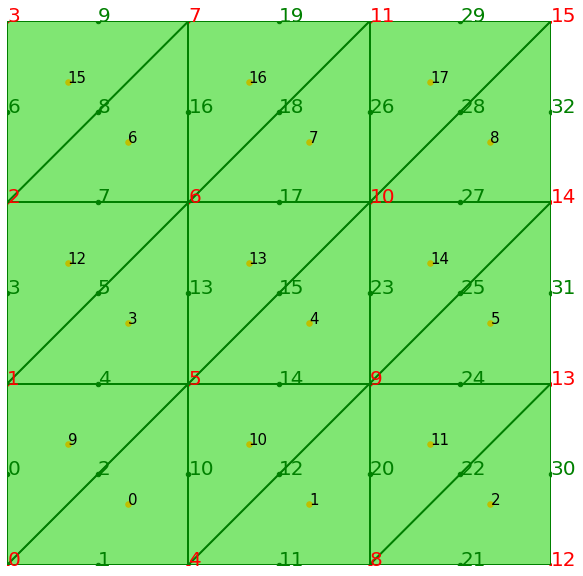

In [25]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,10))
axes=fig.gca()
mesh.add_plot(axes)
mesh.find_node(axes,showindex=True,fontsize=20)
mesh.find_edge(axes,showindex=True,fontsize=20)
mesh.find_cell(axes,showindex=True)
plt.show()

### HuZhangFinite_test_1

In [11]:
mesh.face_unit_normal()
mesh.edge_unit_tagent()

AttributeError: 'TriangleMesh' object has no attribute 'edge_unit_tagent'

In [43]:
huzhang_1=HuZhangfem_test(mesh,p)

## GenLinearElasticitymodel2D

In [4]:
from fealpy.decorator.coordinates import cartesian

class GenLinearElasticitymodel2D():
    def __init__(self,u,x,lam=1,mu=0.5,
                    Dirichletbd_n = None, Dirichletbd_t = None,
                    Neumannbd_nn = None, Neumannbd_nt=None):
        '''
        生成一般线弹性模型,应力边界条件法向和切向能分开 2D
        '''
        dim = len(x)
        div_u = 0
        for i in range(dim):
            div_u+=sp.diff(u[i],x[i],1)

        stress = [[0 for i in range(dim)] for j in range(dim)]
        grad_displacement = [[0 for i in range(dim)] for j in range(dim)]

        for i in range(dim):
            for j in range(i,dim):
                if i == j:
                    stress[i][j] = mu*(sp.diff(u[i],x[j],1)+sp.diff(u[j],x[i],1))+lam*div_u
                else:
                    stress[i][j] = mu*(sp.diff(u[i],x[j],1)+sp.diff(u[j],x[i],1))
                    stress[j][i] = stress[i][j]

        for i in range(dim):
            for j in range(dim):
                grad_displacement[i][j] = sp.diff(u[i],x[j],1)

        


                

        source = [0 for i in range(dim)]

        for i in range(dim):
            for j in range(dim):
                source[i] -= sp.diff(stress[i][j],x[j],1)

        

        self.dim = dim
        self.lam = lam
        self.mu = mu

        self.displacements = np.array(u) 
        self.grad_displacements = np.array(grad_displacement)
        self.sources = np.array(source)
        self.stresss = np.array(stress)

        self.is_dirichletbd_n = Dirichletbd_n
        self.is_dirichletbd_t = Dirichletbd_t

        self.is_neumannbd_nn = Neumannbd_nn
        self.is_neumannbd_nt = Neumannbd_nt
        self.x = x

    def domain(self):
        return np.array([0,1,0,1])


    def init_mesh(self, n=0):
        dim = self.dim
        from fealpy.mesh import TriangleMesh
        node = np.array([
            (0, 0),
            (1, 0),
            (1, 1),
            (0, 1)], dtype=np.float)
        cell = np.array([(1, 2, 0), (3, 0, 2)], dtype=np.int)
        mesh = TriangleMesh(node, cell)

        mesh.uniform_refine(n)
        return mesh 

    def init_trangle_mesh(self, n=0):
        from fealpy.mesh import TriangleMesh
        node = np.array([
            (0, 0),
            (1, 0),
            (0, 1)], dtype=np.float)
        cell = np.array([[0,1,2]],dtype=np.int)
        mesh = TriangleMesh(node, cell)

        mesh.uniform_refine(n)
        return mesh 

    def init_trangle_mesh2(self, n=0):
        from fealpy.mesh import TriangleMesh
        node = np.array([
            (0, 0),
            (1, 0),
            (2, 1)], dtype=np.float)
        cell = np.array([[0,1,2]],dtype=np.int)
        mesh = TriangleMesh(node, cell)

        mesh.uniform_refine(n)
        return mesh 


    @cartesian
    def displacement(self, p):
        return(self.Numpyfunction(self.displacements,p))
                
    @cartesian
    def grad_displacement(self,p):
        return(self.Numpyfunction(self.grad_displacements,p))

    @cartesian
    def stress(self, p):
        return(self.Numpyfunction(self.stresss,p))


    @cartesian
    def div_stress(self,p):
        return -self.source(p)


    @cartesian
    def source(self, p):
        return self.Numpyfunction(self.sources,p)

    @cartesian
    def dirichlet(self, p, n=None, t=None):
        displacement = self.displacement(p) #(NQ,NEbd,gdim)
        shape = p.shape
        val = np.zeros(shape,dtype=np.float)
        if len(shape) >=3:
            bd_type_idx = self.is_dirichlet_boundary(np.mean(p,axis=0))
        else:
            bd_type_idx = self.is_dirichlet_boundary(p)
        
        idx_n, = np.nonzero(bd_type_idx[0])
        if len(idx_n)>0:
            val[...,idx_n,:] += np.einsum('...i,...i,...j->...j',displacement[...,idx_n,:],n[idx_n],n[idx_n]) 
        
        idx_t, = np.nonzero(bd_type_idx[1])
        if len(idx_t)>0:
            val[...,idx_t,:] += np.einsum('...i,...i,...j->...j',displacement[...,idx_t,:],t[idx_t],t[idx_t])

        #print(val)
        return val
        

    @cartesian
    def neumann(self, p, n=None, t=None):
        stress = self.stress(p) #(NEbd,ldof,gdim,gdim)
        stress_n = np.einsum('...ij,...j->...i',stress,n) #(NEbd,ldof,2)
        shape = p.shape
        val = np.zeros(shape,dtype=np.float)

        if len(shape) >= 3:
            bd_type_idx = self.is_neumann_boundary(np.mean(p,axis=1))
        else:
            bd_type_idx = self.is_neumann_boundary(p)
        idx_n, = np.nonzero(bd_type_idx[0])

        if len(idx_n)>0:
            val[idx_n] += np.einsum('...i,...i,...j->...j',stress_n[idx_n],n[idx_n],n[idx_n]) 
        
        idx_t, = np.nonzero(bd_type_idx[1])
        if len(idx_t)>0:
            val[idx_t] += np.einsum('...i,...i,...j->...j',stress_n[idx_t],t[idx_t],t[idx_t])

        return val
        
    @cartesian
    def is_neumann_boundary(self, p):
        shape = (2,)+p.shape[:-1]
        is_neumannbd_idx = np.zeros(shape,dtype = np.bool)
        x0 = p[..., 0]
        x1 = p[..., 1]
        if self.is_neumannbd_nn is not None:
            is_neumannbd_idx[0] = eval(self.is_neumannbd_nn)
        if self.is_neumannbd_nt is not None:
            is_neumannbd_idx[1] = eval(self.is_neumannbd_nt)

        return is_neumannbd_idx 

    @cartesian
    def is_dirichlet_boundary(self, p):
        shape = (2,)+p.shape[:-1]
        is_dirichlet_idx = np.zeros(shape,dtype = np.bool)
        x0 = p[...,0]
        x1 = p[...,1]
        if self.is_dirichletbd_n is not None:
            is_dirichlet_idx[0] = eval(self.is_dirichletbd_n)
        if self.is_dirichletbd_t is not None:
            is_dirichlet_idx[1] = eval(self.is_dirichletbd_t)

        return is_dirichlet_idx

    
    def compliance_tensor(self, phi,lam=None):
        if lam is None:
            lam = self.lam
        mu = self.mu
        dim = self.dim
        aphi = phi.copy()
        t = np.sum(aphi[..., 0:dim], axis=-1)
        aphi[..., 0:dim] -= lam/(2*mu+dim*lam)*t[..., np.newaxis]
        aphi /= 2*mu
        return aphi    


    def Numpyfunction(self,f,p):
        dim = self.dim
        shape = p.shape #(...,dim)
        if dim != shape[-1]:
            print('dimension is not right!')
            return
        else:
            sym_val = f
            val_dim = sym_val.shape
            x = self.x
            if len(val_dim) == 1:  
                shape = shape[:-1]
                shape+=val_dim
                val = np.zeros(shape,dtype=float)                             
                for i in range(val_dim[0]):
                        idx = False
                        for k in range(dim):
                            idx = (idx or (str(x[k]) in str(sym_val[i])))
                        if  idx:
                            lam_val = sp.lambdify(self.x,sym_val[i],'numpy')
                            if dim == 2:
                                val[...,i] = lam_val(p[...,0],p[...,1])
                            elif dim == 3:
                                val[...,i] = lam_val(p[...,0],p[...,1],p[...,2])
                        else:
                            #print(sym_val[i][j])
                            val[...,i]+=float(sym_val[i])
                return val
            elif len(val_dim) == 2:
                shape = shape[:-1]
                shape +=val_dim
                val = np.zeros(shape,dtype=float)   
                for i in range(val_dim[0]):
                    for j in range(val_dim[1]):
                        idx = False
                        for k in range(dim):
                            idx = (idx or (str(x[k]) in str(sym_val[i][j])))
                        if  idx:
                            lam_val = sp.lambdify(self.x,sym_val[i][j],'numpy')
                            if dim == 2:
                                val[...,i,j] = lam_val(p[...,0],p[...,1])
                            elif dim == 3:
                                val[...,i,j] = lam_val(p[...,0],p[...,1],p[...,2])
                        else:
                            #print(sym_val[i][j])
                            val[...,i,j]+=float(sym_val[i][j])
                return val

## LinearElasticityLFEMFastSolver

In [4]:
from fealpy.decorator import timer
class LinearElasticityLFEMFastSolver():
    def __init__(self, A, P, isBdDof):
        """
        Notes
        -----
        A: [[A00, A01], [A10, A11]] (2*gdof, 2*gdof)
        
           [[A00, A01, A02], [A10, A11, A12], [A20, A21, A22]] (3*gdof, 3*gdof)
        P: 预条件子 (gdof, gdof)

        这里的边界条件处理放到矩阵和向量的乘积运算当中, 所心不需要修改矩阵本身
        """
        self.GD = len(A) 
        self.gdof = P.shape[0]

        self.A = A
        self.isBdDof = isBdDof

        # 处理预条件子的边界条件
        bdIdx = np.zeros(P.shape[0], dtype=np.int_)
        bdIdx[isBdDof] = 1
        Tbd = spdiags(bdIdx, 0, P.shape[0], P.shape[0])
        T = spdiags(1-bdIdx, 0, P.shape[0], P.shape[0])
        P = T@P@T + Tbd
        self.ml = pyamg.ruge_stuben_solver(P) 

    def linear_operator(self, b):
        """
        Notes
        -----
        b: (2*gdof, )
        """
        GD = self.GD
        isBdDof = self.isBdDof
        b = b.copy()
        b = b.reshape(GD, -1)
        val = b[:, isBdDof]
        b[:, isBdDof] = 0.0
        r = np.zeros_like(b)
        for i in range(GD):
            for j in range(GD):
                r[i] += self.A[i][j]@b[j]
        r[:, isBdDof] = val
        return r.reshape(-1)

    def preconditioner(self, b):
        GD = self.GD
        b = b.reshape(GD, -1)
        r = np.zeros_like(b)
        for i in range(GD):
            r[i] = self.ml.solve(b[i], tol=1e-8, accel='cg')       
        return r.reshape(-1)

    @timer
    def solve(self, uh, F, tol=1e-8):
        """

        Notes
        -----

        uh 是初值, uh[isBdDof] 中的值已经设为 D 氏边界条件的值, uh[~isBdDof]==0.0
        """

        GD = self.GD
        gdof = self.gdof

        # 处理 Dirichlet 右端边界条件
        for i in range(GD):
            for j in range(GD):
                F[:, i] -= self.A[i][j]@uh[:, j]
        F[isBdDof] = uh[isBdDof]

        A = LinearOperator((GD*gdof, GD*gdof), matvec=self.linear_operator)
        P = LinearOperator((GD*gdof, GD*gdof), matvec=self.preconditioner)
                
        uh.T.flat, info = cg(A, F.T.flat, M=P, tol=1e-8, callback=counter)
        print("Convergence info:", info)
        print("Number of iteration of pcg:", counter.niter)

        return uh 

## begin

In [6]:
import argparse
import numpy as np
import sympy as sp
import sys
from scipy.sparse import coo_matrix, csc_matrix, csr_matrix, spdiags, eye, bmat, construct
from scipy.sparse.linalg import spsolve

import matplotlib.pyplot as plt


import fealpy.mesh.MeshFactory as mf
from fealpy.mesh import TriangleMesh

## function space
# from fealpy.functionspace.mixed_fem_space import HuZhangFiniteElementSpace
from fealpy.functionspace.LagrangeFiniteElementSpace import LagrangeFiniteElementSpace

#linear elasticity model
from fealpy.pde.linear_elasticity_model import QiModel3d, PolyModel3d, Model2d, HuangModel2d
# from fealpy.pde.linear_elasticity_model3D import GenLinearElasticitymodel2D

#solver 
# from fealpy.solver.fast_solver import LinearElasticityHZFEMFastSolve



## error anlysis tool
from fealpy.tools.show import showmultirate

In [8]:
##  参数解析
parser = argparse.ArgumentParser(description=
        """
        三角形网格上用胡张元求解线弹性力学问题
        """)


parser.add_argument('--degree',
        default=3, type=int,
        help='Lagrange 有限元空间的次数, 默认为 3 次.')

parser.add_argument('--nrefine',
        default=2, type=int,
        help='初始网格加密的次数, 默认初始加密 2 次.')

parser.add_argument('--maxit',
        default=4, type=int,
        help='默认网格加密求解的次数, 默认加密求解 4 次')

parser.add_argument('--bdtype',
        default='displacement', type=str,
        help='边界条件, 默认为位移边界')

args = parser.parse_args(args=[])

degree = args.degree
nrefine = args.nrefine
maxit = args.maxit
bdtype = args.bdtype


#由位移生成pde模型
#E = 1e3
#nu = 0.3
#lam = E*nu/((1+nu)*(1-2*nu))
#mu = E/(2*(1+nu))


pi = sp.pi
sin = sp.sin
cos = sp.cos
exp = sp.exp
ln = sp.ln

#给定应力算例
lam = 1
mu = 1

#一般pde算例
x = sp.symbols('x0:2')
#u = [0.01*(1-x[0]),0]
#u = [sin(2*pi*x[0])*sin(2*pi*x[1]),sin(2*pi*x[0])*sin(2*pi*x[1])]
#u = [exp(x[0]+x[1]),exp(x[0]-x[1])]
#u = [x[0],x[1]]
#u = [0,(x[0]-1)**7*(x[1]-1)**7]
u = [-(1-x[0])*ln(1.5-x[0]),-(1-x[0])*ln(1.5-x[1])]
#u = [sin(2*pi*x[0])*sin(2*pi*x[1]),sin(2*pi*x[0])*sin(2*pi*x[1])]


if bdtype == 'displacement': 
        pde = GenLinearElasticitymodel2D(u,x,lam=lam,mu=mu,
                Dirichletbd_n='(x0==1)|(x0==0)|(x1==0)|(x1==1)',
                Dirichletbd_t='(x0==1)|(x0==0)|(x1==0)|(x1==1)')

elif bdtype =='stress_and_displacement':
        pde = GenLinearElasticitymodel2D(u,x,lam=lam,mu=mu,
                Dirichletbd_n='(x1==0)|(x1==1)',Dirichletbd_t='(x1==0)|(x1==1)',
                Neumannbd_nn='(x0==1)|(x0==0)',Neumannbd_nt='(x0==1)|(x0==0)')

elif bdtype =='stress_and_displacement_corner_point':
        pde = GenLinearElasticitymodel2D(u,x,lam=lam,mu=mu,
                Dirichletbd_n='(x0==1)|(x1==1)',Dirichletbd_t='(x0==1)|(x1==1)',
                Neumannbd_nn='(x0==0)|(x1==0)',Neumannbd_nt='(x0==0)|(x1==0)')
                        



mesh = mf.boxmesh2d(pde.domain(),nx=1,ny=1,meshtype='tri')
mesh.uniform_refine(nrefine)



errorType = ['$||\sigma - \sigma_h ||_{0}$',
        '$||div(\sigma - \sigma_h)||_{0}$',
        '$||u - u_h||_{0}$'
        ]
Ndof = np.zeros((maxit,))
errorMatrix = np.zeros((len(errorType), maxit), dtype=np.float)
gdim = 2

run boxmesh2d with time: 0.0012461000005714595


In [ ]:
# pde.domain()
# mesh = mf.boxmesh2d([0,1,0,1],nx=1,ny=1,meshtype='tri')

run boxmesh2d with time: 0.0007719999994151294


In [7]:
HuZhangFiniteElementSpace(mesh, degree)

AttributeError: 'TriangleMesh' object has no attribute 'edge_unit_tagent'

In [7]:
for i in range(maxit):
        print("The {}-th computation:".format(i))

        tspace = HuZhangFiniteElementSpace(mesh, degree)
        vspace = LagrangeFiniteElementSpace(mesh, degree-1, spacetype='D') 

        tgdof = tspace.number_of_global_dofs()
        vgdof = vspace.number_of_global_dofs()

        sh = tspace.function()
        uh = vspace.function(dim=gdim)

        #M = tspace.compliance_tensor_matrix(mu=pde.mu,lam=pde.lam)
        M = tspace.parallel_compliance_tensor_matrix(mu=pde.mu,lam=pde.lam)

        #B0,B1 = tspace.div_matrix(vspace)
        B0,B1 = tspace.parallel_div_matrix(vspace)
        #print(np.max(np.abs(B0-B10)))

        F1 =  -vspace.source_vector(pde.source,dim=gdim)


        #边界处理
        F0 = tspace.set_nature_bc(pde.dirichlet,threshold=pde.is_dirichlet_boundary) #此处以位移边界为dirichlet边界

        isBDdof = tspace.set_essential_bc(sh, pde.neumann,M,B0,B1,F0, threshold=pde.is_neumann_boundary)#以应力边界为neumann边界


        F0 -= M@sh
        F0[isBDdof] = sh[isBDdof]
        F1[:,0] -= B0@sh 
        F1[:,1] -= B1@sh


        bdIdx = np.zeros(tgdof, dtype=np.int)
        bdIdx[isBDdof] = 1
        Tbd = spdiags(bdIdx,0,tgdof,tgdof)
        T = spdiags(1-bdIdx,0,tgdof,tgdof)
        M = T@M@T + Tbd
        B0 = B0@T
        B1 = B1@T



        #求解
        #FF = np.r_[F0,F1.T.reshape(-1)]
        #AA = bmat([[M, B0.transpose(), B1.transpose()],[B0, None, None],[B1,None,None]],format='csr')
        #x = spsolve(AA,FF)

        B = construct.vstack([B0,B1],format='csr')
        A = [M,B]
        F = [F0,F1]
        Fast_slover = LinearElasticityHZFEMFastSolve(A,F,vspace)
        x = Fast_slover.solve()




        sh[:] = x[:tgdof]
        uh[:,0] = x[tgdof:tgdof+vgdof]
        uh[:,1] = x[tgdof+vgdof:]

        gdof = tgdof+gdim*vgdof
        Ndof[i] = gdof

        #有限元误差
        errorMatrix[0,i] = tspace.integralalg.error(pde.stress,sh.value)
        errorMatrix[1,i] = tspace.integralalg.error(pde.div_stress,sh.div_value)
        errorMatrix[2,i] = vspace.integralalg.error(pde.displacement,uh.value)        
        if i < maxit - 1:
                mesh.uniform_refine()

       
print('Ndof:', Ndof)
print('error:', errorMatrix)
showmultirate(plt, 0, Ndof, errorMatrix, errorType)
plt.show()      

The 0-th computation:


AttributeError: 'TriangleMesh' object has no attribute 'edge_unit_tagent'

In [ ]:
display(pi,sin,cos,ln)
display(x)

pi

sin

cos

log

(x0, x1)

In [ ]:
display(u)
display(maxit)
display(Ndof)
np.zeros(3)

[(x0 - 1)*log(1.5 - x0), (x0 - 1)*log(1.5 - x1)]

4

array([0., 0., 0., 0.])

array([0., 0., 0.])

## LinearElasticity_Lagrange

In [10]:
class BoxDomainData2d():
    def __init__(self, E=1e+5, nu=0.2):
        self.E = E 
        self.nu = nu
        self.lam = self.nu*self.E/((1+self.nu)*(1-2*self.nu))
        self.mu = self.E/(2*(1+self.nu))

    def domain(self):
        return [0, 1, 0, 1]

    def init_mesh(self, n=1, meshtype='tri'):
        node = np.array([
            (0, 0),
            (1, 0),
            (1, 1),
            (0, 1)], dtype=np.float64)
        cell = np.array([(1, 2, 0), (3, 0, 2)], dtype=np.int_)
        mesh = TriangleMesh(node, cell)
        mesh.uniform_refine(n)
        return mesh 

    @cartesian
    def displacement(self, p):
        return 0.0

    @cartesian
    def jacobian(self, p):
        return 0.0

    @cartesian
    def strain(self, p):
        return 0.0

    @cartesian
    def stress(self, p):
        return 0.0

    @cartesian
    def source(self, p):
        val = np.array([0.0, 0.0], dtype=np.float64)
        shape = len(p.shape[:-1])*(1, ) + (2, )
        return val.reshape(shape)

    @cartesian
    def dirichlet(self, p):
        val = np.array([0.0, 0.0], dtype=np.float64)
        shape = len(p.shape[:-1])*(1, ) + (2, )
        return val.reshape(shape)

    @cartesian
    def neumann(self, p, n):
        val = np.array([-500, 0.0], dtype=np.float64)
        shape = len(p.shape[:-1])*(1, ) + (2, )
        return val.reshape(shape)

    @cartesian
    def is_dirichlet_boundary(self, p):
        x = p[..., 0]
        y = p[..., 1]
        flag = np.abs(x) < 1e-13
        return flag

    @cartesian
    def is_neumann_boundary(self, p):
        x = p[..., 0]
        y = p[..., 1]
        flag = np.abs(x - 1) < 1e-13
        return flag

    @cartesian
    def is_fracture_boundary(self, p):
        pass

neumann
dirichlet


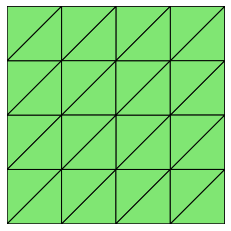

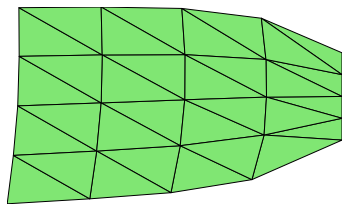

In [13]:
#!/usr/bin/env python3
# 

import argparse
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from fealpy.pde.linear_elasticity_model import  BoxDomainData3d 
from fealpy.functionspace import LagrangeFiniteElementSpace
from fealpy.boundarycondition import DirichletBC
from fealpy.boundarycondition import NeumannBC

from scipy.sparse.linalg import spsolve

from timeit import default_timer as timer


## 参数解析
parser = argparse.ArgumentParser(description=
        """
        单纯形网格（三角形、四面体）网格上任意次有限元方法
        """)

parser.add_argument('--degree',
        default=1, type=int,
        help='Lagrange 有限元空间的次数, 默认为 1 次.')

parser.add_argument('--GD',
        default=2, type=int,
        help='模型问题的维数, 默认求解 2 维问题.')

parser.add_argument('--nrefine',
        default=2, type=int,
        help='初始网格加密的次数, 默认初始加密 2 次.')

parser.add_argument('--scale',
        default=1, type=float,
        help='网格变形系数，默认为 1')


args = parser.parse_args(args=[])
p = args.degree
GD = args.GD
n = args.nrefine
# scale = args.scale
scale=1000


# if GD == 2:
#     from fealpy.pde.linear_elasticity_model import BoxDomainData2d as PDE
# elif GD == 3:
#     from fealpy.pde.linear_elasticity_model import BoxDomainData3d as PDE

pde = BoxDomainData2d()
mesh = pde.init_mesh(n=n)

space = LagrangeFiniteElementSpace(mesh, p=p)



uh = space.function(dim=GD)
A = space.linear_elasticity_matrix(pde.lam, pde.mu, q=p+2)
F = space.source_vector(pde.source, dim=GD)

if hasattr(pde, 'neumann'):
    print('neumann')
    bc = NeumannBC(space, pde.neumann, threshold=pde.is_neumann_boundary)
    F = bc.apply(F)

if hasattr(pde, 'dirichlet'):
    print('dirichlet')
    bc = DirichletBC(space, pde.dirichlet, threshold=pde.is_dirichlet_boundary)
    A, F = bc.apply(A, F, uh)

uh.T.flat[:] = spsolve(A, F)

# 画出原始网格
mesh.add_plot(plt)

# 画出变形网格
mesh.node += scale*uh
mesh.add_plot(plt)

plt.show()


In [14]:
scale

1000

In [17]:
uh

Function([[ 0.00000000e+00,  0.00000000e+00],
          [-4.83505393e-03, -7.29652470e-04],
          [-4.70113132e-03,  5.16833535e-04],
          [ 0.00000000e+00,  0.00000000e+00],
          [-2.45923305e-03, -6.02421625e-04],
          [-2.30161871e-03, -3.83933302e-05],
          [ 0.00000000e+00,  0.00000000e+00],
          [-4.71434570e-03, -1.08257368e-04],
          [-2.33419000e-03,  5.08083712e-04],
          [-1.28180683e-03, -4.52716622e-04],
          [-1.14245478e-03, -1.91707576e-04],
          [ 0.00000000e+00,  0.00000000e+00],
          [-3.63917022e-03, -6.72788180e-04],
          [-4.76446865e-03, -4.25536174e-04],
          [-3.49668232e-03,  2.25452544e-04],
          [-4.69789343e-03,  2.09292718e-04],
          [-3.50875237e-03,  5.24064932e-04],
          [ 0.00000000e+00,  0.00000000e+00],
          [-1.17331874e-03,  3.95883555e-04],
          [-2.35322370e-03, -3.14191035e-04],
          [-3.56015647e-03, -3.75708347e-04],
          [-1.11496536e-03, -7.741

ValueError: all input arrays must have the same shape

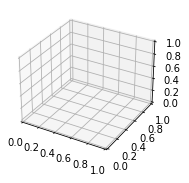

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure()
axes=fig.add_subplot(1,2,1,projection='3d')
uh.add_plot(axes,cmap='rainbow')
axes=fig.add_subplot(1,2,2)
mesh.add_plot(axes)

In [16]:
L2error = space.integralalg.error(pde.solution, uh)
H1error = space.integralalg.error(pde.gradient, uh.grad_value)

print("L2 error: ", L2error)
print("H1 error: ", H1error)

AttributeError: 'BoxDomainData2d' object has no attribute 'solution'